In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# read the data ser
words = open('names.txt','r').read().splitlines()

# Build a vocabulary of characters and a mapping from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

block_size = 3

In [13]:
def build_dataset(words):

  X,Y = [], [] #inputs and targets
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words) #randomly shuffle the words
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [14]:
class Linear:

  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in,fan_out))/ fan_in**0.5
    self.bias = torch.zeros((fan_out)) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [15]:
class BatchNorm1D:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # Parameters (Trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (Trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim = True)  # batch mean
      xvar = x.var(0, keepdim = True, unbiased = True)  # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar - self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) *self.running_mean + self.momentum* xmean
        self.running_var = (1-self.momentum) *self.running_var + self.momentum* xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [16]:
class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [17]:
torch.manual_seed(42) # for reproducability

In [20]:
n_embed = 10 # dimension of the character embedding
n_hidden = 200 # number of hidden neurons in a layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embed),      generator = g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight*= 0.1  # make the last layer less confident

parameters = [C]+ [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [21]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  #mini batch construct
  ix = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb , Yb = Xtr[ix] , Ytr[ix]

  #forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # cross entropy loss

  #backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i<10000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if i%10000 ==0:
    print(f"{i:7d}/ {max_steps:7d}: {loss.item():.4f}")

  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad.std())/p.data.std()).log10().item() for p in parameters])

      0/  200000: 3.2869
  10000/  200000: 2.3386
  20000/  200000: 2.0917
  30000/  200000: 2.4202
  40000/  200000: 2.4449
  50000/  200000: 1.8678
  60000/  200000: 2.1915
  70000/  200000: 1.9700
  80000/  200000: 2.4053
  90000/  200000: 2.0901
 100000/  200000: 2.0791
 110000/  200000: 2.3124
 120000/  200000: 2.2766
 130000/  200000: 1.8756
 140000/  200000: 2.7244
 150000/  200000: 1.9756
 160000/  200000: 2.2235
 170000/  200000: 2.5606
 180000/  200000: 2.1275
 190000/  200000: 1.8724


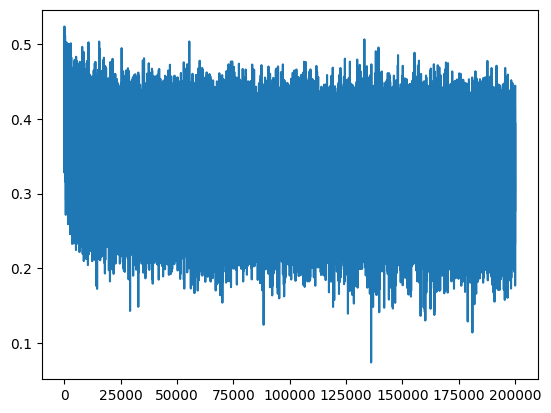

In [22]:
plt.plot(lossi)

In [23]:
# put layers into the eval mode
for layer in layers:
  layer.training = False

In [27]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr,Ytr),
      'val' : (Xdev,Ydev),
      'test': (Xte,Yte)
  }[split]
  emb = C[x]
  x = emb.view(emb.shape[0],-1) # concatenate
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, y)
  print(split, f"{loss.item() : .4f}")

split_loss('train')
split_loss('val')

train  2.0936
val  2.1256
